In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_model = os.path.join(pth_data, 'modeling')
pth_in = os.path.join(pth_model, 'predict')
pth_out = os.path.join(pth_model, 'landscape')
pth_mod = os.path.join(pth_data, 'features', 'biomart', 'modules')
pth_fig = os.path.join(pth, 'figures', 'modeling')

In [3]:
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
src_dict = df.Name.to_dict()

In [4]:
adata = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [5]:
# early/late signatures
mod_names = ['Early', 'Late']
for mod in mod_names:
    print(mod)
    fn = os.path.join(pth_mod, f'{mod.lower()}.csv')
    g = pd.read_csv(fn).mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = mod,
                          random_state = 1234)
        adata.obs.loc[msk, mod] = adata_group.obs[mod]

# save basis
X = adata.obs[mod_names].values
adata.obsm['X_mod'] = X.copy()

Early
Late


In [6]:
# early-late, latent axes => landscape
dims = ['X_mesen1', 'X_mesen2']
dX = (X[:, 1] - X[:, 0]).reshape(-1, 1)
z = adata.obs.latent_z.values.reshape(-1, 1)
X_mesen = np.concatenate((dX, z), axis = 1)
adata.obsm['X_mesen'] = X_mesen.copy()
adata.obs[dims] = X_mesen.copy()

/home/caleb/miniconda3/envs/scanpy/lib/python3.13/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


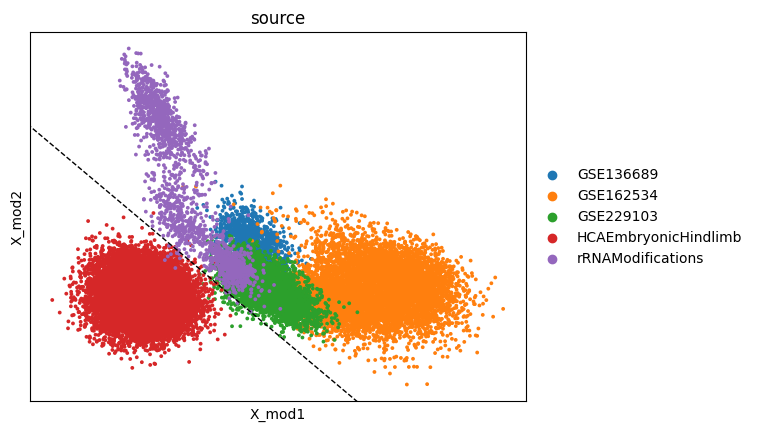

In [7]:
# train/val trajectories
msk_train = (adata.obs.training == 'True')
msk_val = (adata.obs.validation == 'True')
msk_both = (msk_train | msk_val)

# plot early/late signatures
fig, ax = plt.subplots(1, 1)
sc.pl.embedding(adata[msk_both],
                'X_mod', size = 30,
                color = 'source',
                show = False, ax = ax)

# Early + Late = 0
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([-1, 1], [1, -1],
        c = 'k', lw = 1,
        ls = '--')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [8]:
# select landscape trajectories
src = ('GSE162534', 'GSE229103', 'rRNAModifications')
msk_mesen = adata.obs.source.isin(src) & msk_both
adata.obs['landscape'] = msk_mesen.astype(str)

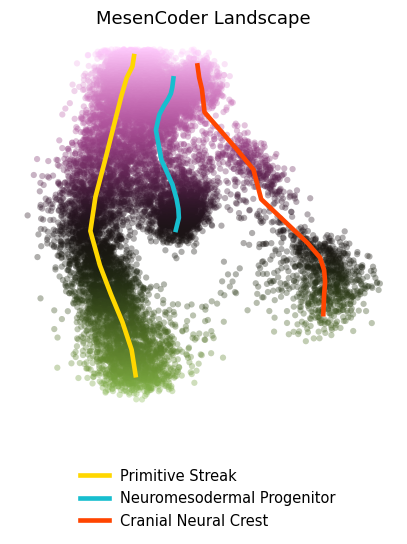

In [10]:
adata_plt = adata[msk_mesen].copy()

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80,
                alpha = .35, color = 'latent_z',
                vmin = 0, vmax = 1, cmap = 'vanimo',
                colorbar_loc = None, show = False,
                frameon = False, ax = ax)

c = {'GSE162534'         : 'gold',
     'GSE229103'         : 'tab:cyan',
     'rRNAModifications' : 'orangered'}

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33,
            color = c[src], label = src_dict[src])

ax.invert_yaxis()
leg = ax.legend(bbox_to_anchor = (.875, -.1),
                frameon = False, fontsize = 10.5)
ax.set_title('MesenCoder Landscape', size = 13)
fn = os.path.join(pth_fig, 'landscape.pdf')
plt.savefig(fn, bbox_inches = 'tight')

In [11]:
# save output
adata.write(os.path.join(pth_out, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z', 'Early', 'Late', 'X_mesen1', 